# Preprocessing and Spectrogram Generation 

In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from skimage.transform import resize

# All the audio files have a sample rate of 48000
sr = 48000
# All the audio clips are under 10 seconds
length = 10*sr

# ResNet50 input layer is 224 x 224 x 3, so I'm resizing the image to fit the first input dimension. 
dimensions = (224,224)

data_path = '../Data/'

In [64]:
#Currently using a melspectrogram, Chromagram SFTF, and SFTF
#Possible other ideas: Chirplet
def generate_spectrograms(df,file_name):
    df['mspec_db'] = np.nan
    df['mspec_db'] = df['mspec_db'].astype(object)
    df['chroma_db'] = np.nan
    df['chroma_db'] = df['chroma_db'].astype(object)
    df['stft_db'] = np.nan
    df['stft_db'] = df['stft_db'].astype(object)

    for idx,row in df.iterrows():
        wav, sr = librosa.load(data_path + 'train/' + row['recording_id'] + '.flac', sr=None)
    
        # Slicing and centering spectograms 
        m = (int)((row['t_min'] + row['t_max'])*sr/2)
    
        l = (int)(m-(length/2))
        r = (int)(m+(length/2))
    
        #Assumes audio files are at least as long as length
        if l < 0:
            r += l
            l = 0
        elif r > len(wav):
            l -= r-len(wav)
            r = len(wav)
        
        #Melspectrogram
        mspec = librosa.feature.melspectrogram(y=wav[l:r], sr=sr, power=2.0)
        mspec_db = librosa.power_to_db(mspec, ref=np.max)
        
        fig, ax = plt.subplots()
        img = librosa.display.specshow(mspec_db, x_axis='time', y_axis='mel', sr=sr, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title='Mel-frequency spectrogram')
        fig.savefig(data_path+'Melspectrograms/'+file_name+'/'+str(idx)+'.png')
        
        #mspec = (mspec - np.min(mspec))/np.max(mspec) normalizing but already on log scale
        mspec_db = resize(mspec_db, dimensions)
        df.at[idx, 'mspec_db'] = mspec_db
        
        #Chroma
        chroma = librosa.feature.chroma_stft(y=wav[l:r], sr=sr)
        chroma_db = librosa.amplitude_to_db(chroma, ref=np.max)
        
        fig, ax = plt.subplots()
        img = librosa.display.specshow(chroma_db, x_axis='time', y_axis='mel', sr=sr, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title='Chromagram')
        fig.savefig(data_path+'Chromagram/'+file_name+'/'+str(idx)+'.png')
        
        #chroma = (chroma - np.min(chroma))/np.max(chroma)
        chroma_db = resize(chroma_db, dimensions)
        df.at[idx, 'chroma_db'] = chroma_db
        
        #Short-time Fourier Transform
        stft = np.abs(librosa.stft(y=wav[l:r]))
        stft_db = librosa.amplitude_to_db(stft, ref=np.max)
        
        fig, ax = plt.subplots()
        img = librosa.display.specshow(stft_db, x_axis='time', y_axis='log', ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title='Power spectrogram')
        fig.savefig(data_path+'stft/'+file_name+'/'+str(idx)+'.png')
        
        #stft_db = (stft_db - np.min(stft_db))/np.max(stft_db)
        stft_db = resize(stft_db, dimensions)
        df.at[idx, 'stft_db'] = stft_db
        
    df.to_csv(data_path+'csv/'+file_name+'_data.csv')

/home/craig/anaconda3/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: '../Data/train/006ab765f.flac'

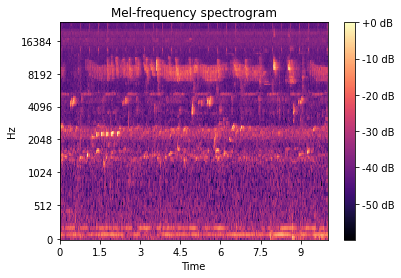

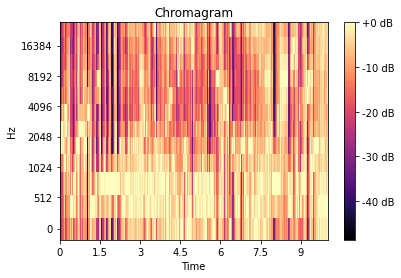

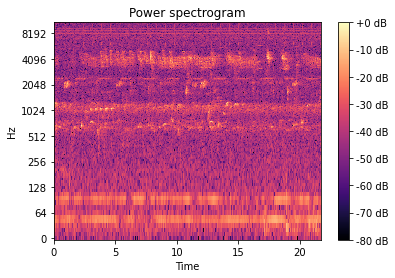

In [65]:
train_tp_df = pd.read_csv(data_path + 'train_tp.csv')
generate_spectrograms(train_tp_df,'train_tp')
train_fp_df = pd.read_csv(data_path + 'train_fp.csv')
generate_spectrograms(train_fp_df,'train_fp')